In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import copy

import matplotlib.pyplot as plt

In [2]:
from Gan_convolutional import Discriminator, Generator, generate_random_image, generate_random_one_hot, generate_random_seed 

In [3]:
# check if CUDA is available

if torch.cuda.is_available():

    torch.set_default_tensor_type(torch.cuda.FloatTensor)

    print("Training cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training cuda: NVIDIA GeForce GTX 1050 Ti


In [4]:
#载入原始数据
data=[]

with h5py.File('../GAN/MC_2layers_T_BC.hdf5', 'r') as f:

    for i in np.arange(1,21):   
    
        dataset=f[str(i)+'.0K']
    
        data.append(copy.deepcopy(dataset[:]))
data=np.array(data)

data=data.reshape(-1,2,10,10)
data.shape

(10000, 2, 10, 10)

5603


array([-0.79526817,  0.77292373])

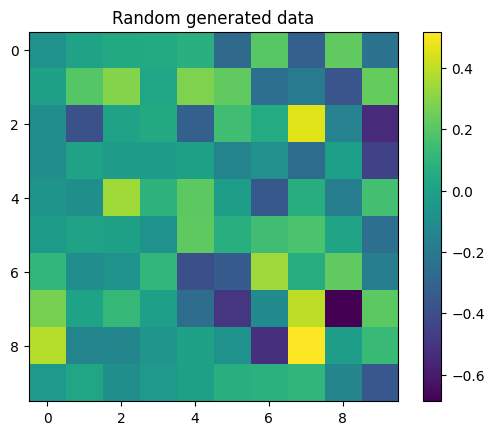

In [5]:
ii=np.random.randint(0,10000)
print(ii)
#original data plotting
plt.imshow(data[ii].sum(axis=0))#.cpu().detach().numpy()
plt.title('Random generated data')
plt.colorbar()
data[ii].reshape(2,-1).sum(axis=1)/100

In [8]:
data_num = 20
T = np.linspace(1,20,data_num)

#创建热独编码
One_hot_code=[]
for i in range(len(T)):
    for j in range(500):
        code=np.zeros(len(T))
        code[i]=1
        One_hot_code.append(code)
One_hot_code=np.array(One_hot_code)

#数据做变形,处于0到1之间,并将其和热独码转为tensor
data_set=(data+1)/2

data_set=torch.tensor(data_set).to(torch.float32)

One_hot_code=torch.tensor(One_hot_code).to(torch.float32)

print(data_set.detach().shape)
print(One_hot_code.detach().shape)

#将数据和标签集中在一起
data_all=[]
for i in range(10000):
    data_all.append([data_set[i], One_hot_code[i]])

torch.Size([10000, 2, 10, 10])
torch.Size([10000, 20])


In [10]:
batch_size=250

data_loader = torch.utils.data.DataLoader(dataset=data_all,
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          generator=torch.Generator(device = 'cuda'))

## Train Discriminator

In [21]:
%%time
epochs=100
v_dim = 2*10*10
h_dim = 500
z_dim = 40
learning_rate = 2e-4
class_num=len(T)

model_D = Discriminator( h_dim=h_dim,learning_rate=learning_rate, class_num=class_num)
# move model to cuda device
model_D.to(device)


losses = []

for epoch in np.arange(epochs):

    train_loss=0 
    

    for image_data, label_tensor in data_loader:

        image_data = image_data.to(device)
        label_tensor = label_tensor.to(device)

        # real_imgs = image_data.view(-1,v_dim)

        model_D.train(image_data, label_tensor, torch.ones(batch_size,1))# torch.cuda.FloatTensor([1.0])
        train_loss += model_D.Loss.detach().item()

        # fake data
        model_D.train(generate_random_image(batch_size).cuda(), generate_random_one_hot(batch_size, class_num), torch.zeros(batch_size,1))
        train_loss += model_D.Loss.detach().item()
    
    if (epoch+1)%10==0:
        print('Epoch: {}, loss: {}'.format(epoch+1, train_loss / (2*len(data_loader))))

    losses.append(train_loss / (2*len(data_loader)))
        

Epoch: 10, loss: 0.16768787883222103
Epoch: 20, loss: 0.10238403674215078
Epoch: 30, loss: 0.04704895714297891
Epoch: 40, loss: 0.03792524197953753
Epoch: 50, loss: 0.021592570820066614
Epoch: 60, loss: 0.022766755367993028
Epoch: 70, loss: 0.013414754518889823
Epoch: 80, loss: 0.01328311614866834
Epoch: 90, loss: 0.014161354946409119
Epoch: 100, loss: 0.013849774288537446
Epoch: 110, loss: 0.008001619167298486
Epoch: 120, loss: 0.008282087357365527
Epoch: 130, loss: 0.007919534536522405
Epoch: 140, loss: 0.006863358406044426
Epoch: 150, loss: 0.006249304854645743
Epoch: 160, loss: 0.006208074672995281
Epoch: 170, loss: 0.0072486845930325216
Epoch: 180, loss: 0.007321900969391209
Epoch: 190, loss: 0.005148786762774762
Epoch: 200, loss: 0.005175844997470449
Wall time: 13min 50s


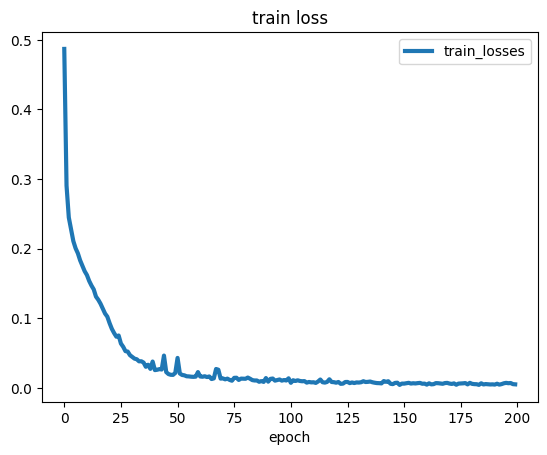

In [22]:
# plot discriminator loss
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses, linewidth=3, linestyle='-', label='train_losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [25]:
# manually run discriminator to check it can tell real data from fake
print('T')
for i in range(5): 
  
    A_label = np.random.randint(0,25000)
    image_data_tensor =data_set[A_label]# celeba_dataset[random.randint(0,20000)]

    One_hot_code_tensor=torch.zeros(class_num)
    One_hot_code_tensor[int(A_label/500)]=1.0

    print( model_D.forward( image_data_tensor.reshape(-1,2,10,10),One_hot_code_tensor.reshape(-1,50)).item() )
  
print('F')
for i in range(5):

    print( model_D.forward( generate_random_image(1).reshape(-1,2,10,10), generate_random_one_hot(1,50)).item() )

T
0.9998238682746887
1.0
0.9997400641441345
0.9999097585678101
0.9999833106994629
F
1.485431379679228e-13
1.4168072937081888e-07
2.882342187149334e-07
1.4008582929760322e-16
6.976690780646777e-09


## Train GAN

In [20]:
%%time 
v_dim = 2*10*10
z_dim = 20
h_dim=500
learning_rate=1e-4
epochs = 250
class_num=len(T)

# create Discriminator and Generator

D_model = Discriminator( h_dim=h_dim, learning_rate=learning_rate, class_num=class_num)
D_model.to(device)
G_model = Generator(h_dim=h_dim, z_dim=z_dim, learning_rate=learning_rate, class_num=class_num)#+400
G_model.to(device)#+500+200

D_losses = []
G_losses = []

for epoch in range(epochs):

    d_loss=0
    g_loss=0

    for image_data_tensor, label_tensor in data_loader:
        # image_data_tensor = torch.flatten(image_data_tensor)#, start_dim=1

        D_model.train(image_data_tensor, label_tensor, torch.ones(batch_size,1))#torch.cuda.FloatTensor([1.0])
        d_loss += D_model.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        D_model.train(G_model.forward(generate_random_seed(batch_size,z_dim), Genetated_random_hot).detach(), Genetated_random_hot, torch.zeros(batch_size,1)) # torch.cuda.FloatTensor([0.0])
        d_loss += D_model.Loss.detach().item()

        Genetated_random_hot=generate_random_one_hot(batch_size, class_num)

        G_model.train(D_model, generate_random_seed(batch_size,z_dim), Genetated_random_hot, torch.ones(batch_size,1) )#torch.cuda.FloatTensor([1.0])
        g_loss += G_model.Loss.detach().item()

    if (epoch+1)%20==0:
        print('Epoch: {}, D_loss: {}, G_loss: {}'.format(epoch+1, d_loss / (2*len(data_loader)),g_loss / len(data_loader)))

    D_losses.append(d_loss / (2*len(data_loader)))
    G_losses.append(g_loss / len(data_loader))

Epoch: 20, D_loss: 0.31445386484265325, G_loss: 1.945955115556717
Epoch: 40, D_loss: 0.5375069990754128, G_loss: 1.2143051505088807
Epoch: 60, D_loss: 0.5982446119189262, G_loss: 1.125952246785164
Epoch: 80, D_loss: 0.528823635354638, G_loss: 1.2512532949447632
Epoch: 100, D_loss: 0.5784966181963682, G_loss: 1.1995885759592055
Epoch: 120, D_loss: 0.6159814119338989, G_loss: 1.0510020837187768
Epoch: 140, D_loss: 0.6268923513591289, G_loss: 1.0492998465895653
Epoch: 160, D_loss: 0.58085075058043, G_loss: 1.138783299922943
Epoch: 180, D_loss: 0.5809395805001258, G_loss: 1.0908005565404892
Epoch: 200, D_loss: 0.5763956002891064, G_loss: 1.1301772534847259
Epoch: 220, D_loss: 0.6478706169873476, G_loss: 1.0341610491275788
Epoch: 240, D_loss: 0.7133157633244991, G_loss: 0.8979683369398117
Wall time: 8min 45s


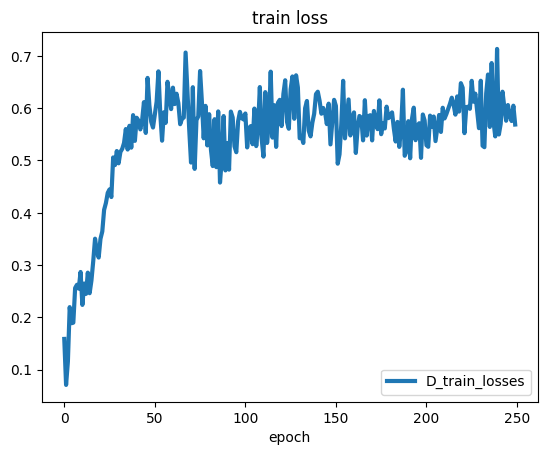

In [23]:
# plot discriminator error
plt.title('train loss')
plt.plot(np.arange(len(D_losses)), D_losses, linewidth=3, linestyle='-', label='D_train_losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

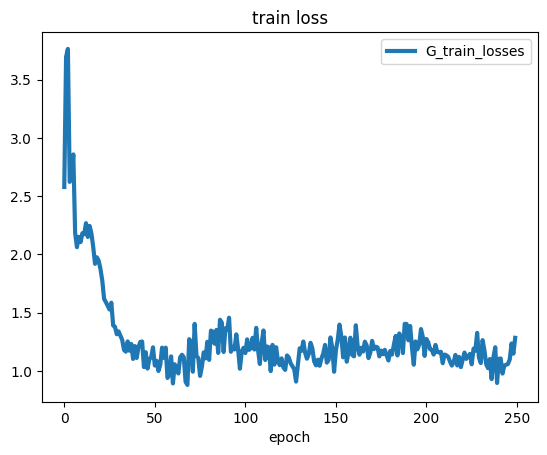

In [24]:
# plot generator error
plt.title('train loss')
plt.plot(np.arange(len(G_losses)), G_losses, linewidth=3, linestyle='-', label='G_train_losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Run Generator

[-0.6645973  0.795433 ]


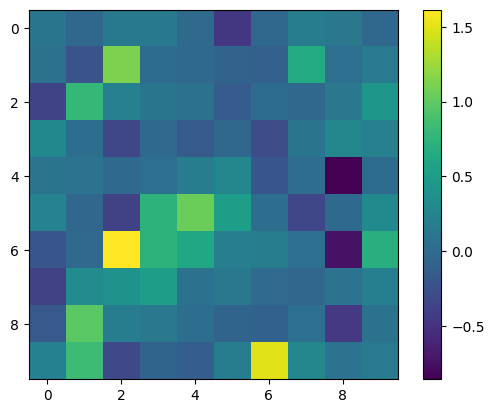

In [27]:
T_test=11
Code=torch.zeros(20)
Code[T_test-1]=1.0
output=G_model.forward(generate_random_seed(1,z_dim), Code.reshape(1,20))
img = output.detach().cpu().numpy().reshape(2,10,10)
generated_img=img*2-1
plt.imshow(generated_img.sum(axis=0))
plt.colorbar()

print(generated_img.sum(axis=1).sum(axis=1)/100)

## Create data for magnetic measurement

In [28]:
M_T=[]
Susceptibility = []
sample_num=500
for ii in range(0,len(T)):
    Code=torch.zeros(20)
    Code[ii]=1.0

    
    cal_M = 0
    cal_M_2=0
    for jj in range(sample_num):
        output=G_model.forward(generate_random_seed(1,z_dim), Code.reshape(1,20))
        img = output.detach().cpu().numpy().reshape(2,10,10)
        generated_img=img*2-1
        cal_M += generated_img.sum()/100
        cal_M_2 += (generated_img.sum()/100)**2
    cal_M = cal_M/sample_num
    cal_M_2 = cal_M_2/sample_num


    M_T.append(copy.deepcopy(cal_M))
    Susceptibility.append(copy.deepcopy((1/(ii+1))*(cal_M_2-cal_M**2)))

M_T=np.array(M_T)
Susceptibility=np.array(Susceptibility)

Text(0.5, 0, 'Temperature (K)')

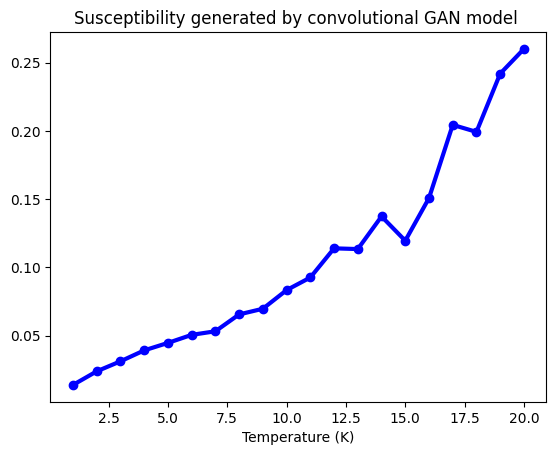

In [29]:
plt.plot(T, M_T,'bo-',markersize=6,lw=3)
plt.title('Susceptibility generated by convolutional GAN model ')
plt.xlabel('Temperature (K)')

Text(0.5, 0, 'Temperature (K)')

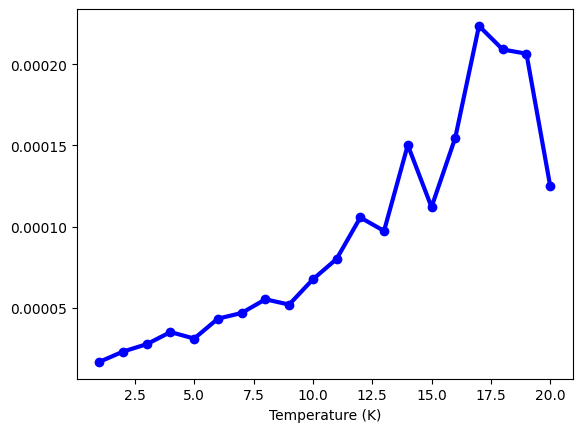

In [30]:
plt.plot(T, Susceptibility,'bo-',markersize=6,lw=3)
plt.xlabel('Temperature (K)')

## Model saving